In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools
import xarray as xr
import datetime
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [21]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV1'
nowcast_data = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV17-02'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)
nowcast = xr.open_dataset(nowcast_data)

In [4]:
nc.num2date(ferry.variables['s.time'][680000], ferry.variables['s.time'].units)

datetime.datetime(2014, 9, 13, 5, 20)

In [5]:
nc.num2date(ferry.variables['s.time'][-1], ferry.variables['s.time'].units)

datetime.datetime(2017, 10, 27, 15, 12)

In [6]:
import pickle

In [7]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [8]:
import os

In [8]:
list_of_model_chl = np.array([])
list_of_ferry_chl = np.array([])
unit = ferry.variables['s.time'].units
for n in range(680000, 1450392):
    if ((ferry.variables['s.latitude'][n].mask == False) 
        and (ferry.variables['s.chlorophyll'][n].mask == False)):
        Yind, Xind = geo_tools.find_closest_model_point(ferry.variables['s.longitude'][n], 
                                                        ferry.variables['s.latitude'][n], 
                                                        X, Y, land_mask = bathy.mask)
        date = nc.num2date(ferry.variables['s.time'][n], unit)
        sub_dir = date.strftime('%d%b%y').lower()
        datestr = date.strftime('%Y%m%d')
        fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
        nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
        if date.minute < 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date - before).seconds / 3600
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                       (1- delta)*(nuts2.variables['diatoms'][after.hour, 1, Yind, Xind] 
                           + nuts2.variables['ciliates'][after.hour,1,Yind, Xind] 
                           + nuts2.variables['flagellates'][after.hour,1,Yind,Xind]))
        if date.minute >= 30:
            before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30)
            after = before + datetime.timedelta(hours=1)
            sub_dir2 = after.strftime('%d%b%y').lower()
            datestr2 = after.strftime('%Y%m%d')
            fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
            nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
            delta = (date - before).seconds / 3600
            chl_val = 1.6*(delta*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                       (1- delta)*(nuts.variables['diatoms'][after.hour, 1, Yind, Xind] 
                           + nuts.variables['ciliates'][after.hour,1,Yind, Xind] 
                           + nuts.variables['flagellates'][after.hour,1,Yind,Xind]))
        list_of_ferry_chl = np.append(list_of_ferry_chl, ferry.variables['s.chlorophyll'][n])
        list_of_model_chl = np.append(list_of_model_chl, chl_val)

In [11]:
output = open('ferry_chl.pkl', 'wb')
pickle.dump(list_of_ferry_chl, output)
output.close()
output = open('model_chl.pkl', 'wb')
pickle.dump(list_of_model_chl, output)
output.close()

In [9]:
list_of_model_chl = pickle.load(open('model_chl.pkl', 'rb'))
list_of_ferry_chl = pickle.load(open('ferry_chl.pkl', 'rb'))

In [11]:
list_of_ferry_chl.shape

(422789,)

In [12]:
print('bias =  ' + str(-np.mean(list_of_ferry_chl) + np.mean(list_of_model_chl)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl - list_of_ferry_chl)**2) / len(list_of_model_chl))))
xbar = np.mean(list_of_ferry_chl)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl - list_of_ferry_chl)**2)  / 
                             np.sum((np.abs(list_of_model_chl - xbar) + np.abs(list_of_ferry_chl - xbar))**2))))

bias =  2.18282683221
RMSE = 4.86143879112
Willmott = 0.498952254572


In [13]:
from matplotlib.colors import LogNorm

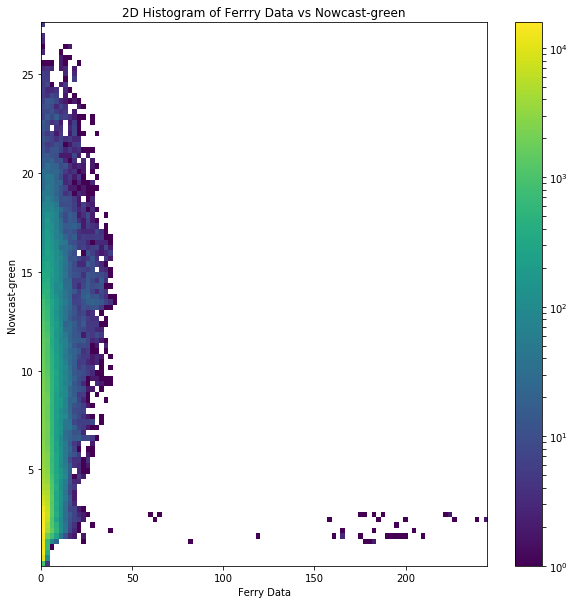

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferry_chl, list_of_model_chl, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Nowcast-green')
ax.set_title('2D Histogram of Ferrry Data vs Nowcast-green')

In [24]:
list_of_ferry_chl.max()

244.87272727272727

In [36]:
list_of_model_chl[232993]

2.396269175211589

In [37]:
list_of_ferry_chl[232993]

244.87272727272727

In [20]:
list_of_ferry_chl[list_of_ferry_chl > 30]

masked_array(data = [30.108833333333333 30.68358333333333 31.806866666666668 32.78495
 32.43203333333333 31.096999999999998 31.433783333333334 32.94225
 32.73049999999999 32.6821 31.298666666666666 31.83106666666667
 31.385383333333333 31.699983333333332 30.973983333333337 31.0244
 31.647549999999995 31.437816666666663 30.907433333333334
 30.818700000000003 30.3468 31.939966666666667 35.71113333333333
 37.844766666666665 38.44371666666667 38.346916666666665 37.10061666666667
 35.83213333333334 35.382416666666664 34.68061666666667 35.85431666666666
 36.87878333333333 36.79408333333333 36.77996666666667 37.15506666666667
 37.2922 36.31411666666666 34.837916666666665 30.7461 30.55855 33.0451
 34.374083333333324 34.952866666666665 35.25536666666667 36.65493333333333
 37.68141666666667 37.7399 37.90325 38.657483333333325 37.11675
 37.07843333333333 35.7555 36.10438333333333 36.64485 35.3199 34.16435
 30.980033333333328 31.87745 30.354866666666663 30.651316666666663
 32.91603333333333 33.839

In [19]:
list_of_model_chl[list_of_ferry_chl > 30]

array([ 16.0609199 ,  16.9960275 ,  17.03168335,  16.97576032,
        17.16207306,  17.5095491 ,  16.93340698,  16.56008362,
        16.35156118,  16.39699768,  16.45778135,  13.34742844,
        13.60563649,  13.34959386,  13.18962326,  13.07987473,
        13.77996445,  14.27822398,  14.19580322,  13.84664563,
        13.7927477 ,  13.46918416,  13.85805145,  13.6571257 ,
        13.3351121 ,  13.26109009,  14.29838336,  14.16506495,
        13.55250137,  13.57130188,  14.94573402,  15.88035355,
        14.69462156,  15.63660848,  15.84538635,  16.79125163,
        17.19527252,  17.81664948,  18.01495738,  16.29574371,
        16.16375148,  16.41362442,  16.09313942,  16.20834727,
        16.42292918,  16.0122612 ,  15.94166667,  15.91943095,
        16.11975815,  16.01026072,  15.67374001,  15.7677002 ,
        15.56084106,  13.88717031,  13.86907372,  13.97059631,
        14.72307014,  15.34856789,  14.71907552,  14.34944305,
        14.43759511,  14.82921473,  15.55731735,  16.19